# 数据爬取

In [2]:
from selenium import webdriver
import os
import requests
import pickle
import numpy as np
import pandas as pd

In [27]:
import re

In [3]:
product_url = r'https://item.jd.com/5561746.html#none'

In [4]:
driver = webdriver.Chrome()

In [5]:
driver.get(product_url)

In [94]:
good_comments_url = r'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98&productId=5561746&score=3&sortType=5&page=0&pageSize=10&isShadowSku=0&fold=1'
bad_comments_url = r'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98&productId=5561746&score=1&sortType=5&page=0&pageSize=10&isShadowSku=0&fold=1'

In [182]:
header = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_1_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36',
}
param = {
    'callback': 'fetchJSON_comment98',
    'productId': '5561746',
    'score': '3',
    'sortType': '5',
    'page': '',
    'pageSize': '10',
    'isShadowSku': '0',
    'fold': '1',
}
cookie = {
    'Cookie': 'shshshfpa=cb4386b6-c0f2-68a1-b156-2236f499ee30-1590065631; shshshfpb=dXHF9pqH0l8XV8dgbxTlNEQ%3D%3D; __jdu=15900656294791955369661; user-key=3e85b9e4-c7cf-43fd-9e1a-756e9776cab0; cn=0; __jdc=122270672; areaId=19; ipLoc-djd=19-1607-3155-0; shshshfp=83f76a7577a1d3cdcb7f20cd9a99ba87; __jdv=122270672|github.com|-|referral|-|1617588163257; jwotest_product=99; __jda=122270672.15900656294791955369661.1590065629.1617593724.1617596142.26; shshshsID=273af6177249142f26677cc915a91991_2_1617597325824; __jdb=122270672.2.15900656294791955369661|26.1617596142; JSESSIONID=EDBD2A6AD8E18761AFF846595478748F.s1; 3AB9D23F7A4B3C9B=NYA7Y2IYQW7V35YN3PSDHABICJZ5GIKPEEIE6XO7TSEUVYNHVZ7CFQHTY2RYGTGNNEFG2YNVNV5ZYJC36L2IOMHRSM'
}

In [153]:
session = requests.Session()
cookie = requests.utils.cookiejar_from_dict(cookie)
session.cookies = cookie
res = session.get(url=good_comments_url, headers=header, data=param)

In [154]:
good_comments = re.findall(r'fetchJSON_comment98\((.*)\)', res.text)[0]

In [155]:
type(good_comments)

str

In [103]:
import json

In [104]:
good_comments = json.loads(good_comments)

In [105]:
type(good_comments)

dict

In [148]:
from tqdm import tqdm
import time

In [183]:
def get_good_comments(header, param, cookie, scrap_page=200):
    session = requests.Session()
    session.cookies = requests.utils.cookiejar_from_dict(cookie)
    scrap_page = scrap_page
    fail = 0
    comments = []
    for page in tqdm(range(scrap_page)):
        good_comments_url = f'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98&productId=5561746&score=3&sortType=5&page={page}&pageSize=10&isShadowSku=0&fold=1'
        try:
            res = session.get(url=good_comments_url, headers=header, data=param)
            good_comments = re.findall(r'fetchJSON_comment98\((.*)\)', res.text)[0] # 本来获取的是json数据，但是前面加了字符串，所以要删除
            good_comments = json.loads(good_comments) # 将字符串转换成字典
            for itm in good_comments['comments']:
                comments.append(itm['content'])
            time.sleep(1)
        except Exception as e:
            fail += 1
            continue
    print(f'\n成功的页数为:{scrap_page - fail}失败的页数为:{fail}')
    return comments

In [184]:
good_comments = get_good_comments(header=header, param=param, cookie=cookie, scrap_page=150)

100%|██████████| 300/300 [02:59<00:00,  1.67it/s]
成功的页数为:119失败的页数为:181



In [185]:
len(good_comments)

1000

In [179]:
with open('./data/good_comments.pkl', 'wb') as f:
    pickle.dump(good_comments, f)

In [180]:
t = pickle.load(open('./data/good_comments.pkl', 'rb'))

In [ ]:
def get_good_comments(header, param, cookie, scrap_page=200):
    session = requests.Session()
    session.cookies = requests.utils.cookiejar_from_dict(cookie)
    scrap_page = scrap_page
    fail = 0
    comments = []
    for page in tqdm(range(scrap_page)):
        good_comments_url = f'https://club.jd.com/comment/productPageComments.action'
        try:
            res = session.get(url=good_comments_url, headers=header, data=param)
            good_comments = re.findall(r'fetchJSON_comment98\((.*)\)', res.text)[0] # 本来获取的是json数据，但是前面加了字符串，所以要删除
            good_comments = json.loads(good_comments) # 将字符串转换成字典
            for itm in good_comments['comments']:
                comments.append(itm['content'])
            time.sleep(1)
        except Exception as e:
            fail += 1
            continue
    print(f'\n成功的页数为:{scrap_page - fail}失败的页数为:{fail}')
    return comments

# 数据处理

In [1]:
import os
import pickle
import re
import numpy as np
import pandas as pd

In [2]:
os.listdir('./data')

['pool_comments.pkl', 'good_comments.pkl']

In [3]:
good_comments = pickle.load(open('./data/good_comments.pkl', 'rb'))

In [4]:
pool_comments = pickle.load(open('./data/pool_comments.pkl', 'rb'))

In [5]:
len(set(good_comments)), len(set(pool_comments)) # 怕有些数据重复，所以使用set去重

(1000, 994)

## 中文文本分词

- 数据清洗
- 分词

In [12]:
import jieba
import jieba.posseg
import re
from tqdm import tqdm

In [15]:
def clear_sentence(comments):
    for idx, sentence in enumerate(tqdm(comments)):
        temp1 = re.sub("[a-zA-Z0-9]", "", sentence) # 清除
        temp2 = re.sub("[\s+\.\!\/_,$%^*(+\"\'；：“”．]+|[+——！，。？?、~@#￥%……&*（）]+", "", temp1) # 清除标点符号
        comments[idx] = temp2
    return comments

In [16]:
clr_good_comments = clear_sentence(good_comments)
clr_pool_comments = clear_sentence(pool_comments)

100%|██████████| 1000/1000 [00:00<00:00, 230039.16it/s]


In [20]:
' '.join(jieba.cut(clr_good_comments[0])) #  这里直接返回的是一个迭代器

'期待已久 的 洗面奶 终于 到手 了 洗面奶 真的 是 好 用 物美 超值 用 完 不 油腻 不 紧绷 清爽 一整天 温和 不 刺激 性价比 也 真的 是 超高 适合 每 一个 年龄段 使用 尤其 是 控油 效果 特别 好 第二次 买 欧莱雅 的 产品 了 品质 非常 不错 以前 都 是 听 朋友 推荐 来 买 的 第一次 用 就 觉得 很 不错 已 推荐 同事 买 了 真心 不错'

In [23]:
def seg_comments(comments):
    for idx, sentence in enumerate(tqdm(comments)):
        comments[idx] = ' '.join(jieba.cut(sentence, cut_all=False))
    return comments

In [24]:
seg_good_comments = seg_comments(clr_good_comments)
seg_pool_comments = seg_comments(clr_pool_comments)

100%|██████████| 1000/1000 [00:00<00:00, 11547.78it/s]


In [27]:
seg_good_comments[0] # 清洗完后的数据如下

'期待已久 的 洗面奶 终于 到手 了 洗面奶 真的 是 好 用 物美 超值 用 完 不 油腻 不 紧绷 清爽 一整天 温和 不 刺激 性价比 也 真的 是 超高 适合 每 一个 年龄段 使用 尤其 是 控油 效果 特别 好 第二次 买 欧莱雅 的 产品 了 品质 非常 不错 以前 都 是 听 朋友 推荐 来 买 的 第一次 用 就 觉得 很 不错 已 推荐 同事 买 了 真心 不错'

## 停用词处理

In [29]:
os.listdir('./data/')

['pool_comments.pkl', 'good_comments.pkl', 'stopWord.txt']

In [43]:
with open('./data/stopWord.txt', 'r') as f:
    stop_words = []
    for word in f.readlines():
        stop_words.append(word.strip())

In [48]:
stop_words[10:20] # 查看停用词处理

['：', '；', '？', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎哟']

In [51]:
seg_good_comments[0].split(' ')[:4]

['期待已久', '的', '洗面奶', '终于']

In [54]:
res = []
for sentence in seg_good_comments:
    temp = ''
    for word in sentence.split(' '):
        if word not in stop_words:
            temp = ' '.join([temp, word])
    res.append(temp.strip())

In [133]:
def del_stop_words(comments):
    res = []
    for sentence in tqdm(comments):
        temp = []
        for word in sentence.split(' '):
            if word not in stop_words:
                temp.append(word.strip())
        res.append(temp)
    return res

In [134]:
pos_comments = del_stop_words(seg_good_comments)
neg_comments = del_stop_words(seg_pool_comments)

100%|██████████| 1000/1000 [00:00<00:00, 6273.73it/s]


# 获得词向量

这里获得中文的word2vect向量

参考：https://blog.csdn.net/shuihupo/article/details/85162237

两个问题：
- 句子长度不一样怎么处理
- 是使用所有语句进行训练还是分开训练w2v

In [62]:
import gensim
import numpy as np
import pandas as pd

In [63]:
from gensim.models import Word2Vec

In [108]:
import multiprocessing

In [169]:
from collections import Counter

In [144]:
comments = pos_comments + neg_comments # 这里使用全部的语句进行

In [151]:
sub_words = [word for sentence in comments for word in sentence] # 进行拆分,相当于下面代码

# for sentence in comments:
#     for word in sentence:
#         sub_words.append(word)

In [153]:
count_words = Counter(sub_words) # 字典结构，键为单词，值为出现的次数

In [155]:
sort_words = sorted(count_words.items(), key=lambda x:x[1], reverse=True) # 形成字典结构。但是为按词频从大到小排序

In [159]:
words = [item[0] for item in sort_words] # 获得排序好的单词

In [109]:
model = Word2Vec(comments, min_count=1, iter=20, size=128, window=5, workers=multiprocessing.cpu_count()) # 注意输入的格式为[['',''], ['', '']]

In [110]:
model.save('./data/w2vModel')
# model = Word2VecModel.load('./data/w2vModel')

In [102]:
len(comments[2]), model[comments[2]].shape # 句子长度不一样，怎么处理？将每个词转换成了向量

<ipython-input-102-0a8c86aa1953>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  len(comments[2]), model[comments[2]].shape


(29, (29, 128))

In [106]:
len(model[comments[2]]), np.sum(model[comments[2]])

<ipython-input-106-972a839c011c>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  len(model[comments[2]]), np.sum(model[comments[2]])


(29, -24.246601)

In [208]:
def get_embedding(words, model):
    '''
    构建look up table
    '''
    vocab = []
    embedding = []
    vocab.append('pad')
    embedding.append(np.zeros((128))) # 如果是pad就填充0向量,因为句子长度不一样。这里每个单词的向量长度为128
    for word in tqdm(words):
        try:
            vocab.append(word)
            embedding.append(model[word])
        except:
            pass # 去除掉一些为空的字符
    return vocab, embedding

In [209]:
vocab, embedding = get_embedding(words, model) # 将每个单词和他的向量对应起来

  0%|          | 0/4669 [00:00<?, ?it/s]<ipython-input-208-ce333f5d95a1>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding.append(model[word])
100%|██████████| 4669/4669 [00:00<00:00, 165235.41it/s]


In [211]:
word_2_index = dict(zip(vocab, list(range(len(vocab)))))

In [213]:
word_2_index[words[0]]

1

In [263]:
index_2_word = dict(zip(list(range(len(vocab))), vocab))

In [264]:
index_2_word[1]

'效果'

然后将数据集中的评论词，根据词表，映射为index表示

每个评论，使用index组成的定长数组表示

In [220]:
t = np.zeros((128))

In [229]:
max_len = 0
min_len = 0
all_len = []
for sentence in comments:
    max_len = max(max_len, len(sentence))
    min_len = min(float('inf'), len(sentence))
    all_len.append(len(sentence))

In [228]:
max_len, min_len # 评论中最长的和最短的评论长度

(234, 2)

In [231]:
np.asarray(all_len).mean() # 平均长度为20

20.685

In [232]:
import matplotlib.pyplot as plt

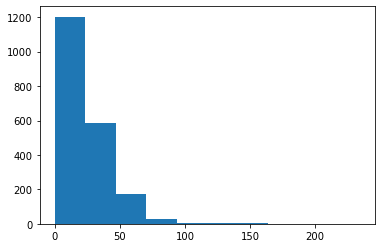

In [235]:
plt.figure()
plt.hist(all_len) # 可以发现大部分评论长度都是在25左右，所以这里设置为40为最大长度
plt.show()

In [241]:
def comments_process(comments, word_2_index, max_len=40):
    '''
    将每个条评论转换成index组成的向量，同时对长度进行补全，因为评论的单词长短不一，所以要设置成一样的。
    '''
    comments_idx = np.zeros((len(comments), max_len)) # 初始化矩阵
    for sentence_idx, sentence in enumerate(tqdm(comments)):
        temp = np.zeros((max_len))
        for word_idx in range(max_len):
            word = sentence[word_idx] if word_idx < len(sentence) else 'pad'
            temp[word_idx] = word_2_index[word]
        comments_idx[sentence_idx] = temp
    return comments_idx

In [242]:
comments_idx = comments_process(comments, word_2_index)

100%|██████████| 2000/2000 [00:00<00:00, 57392.93it/s]


In [244]:
comments_idx, comments_idx.shape

(array([[1220.,    5.,  520., ...,   63.,   10.,  164.],
        [  69.,  276.,  261., ...,    0.,    0.,    0.],
        [   5.,  707.,  152., ...,    0.,    0.,    0.],
        ...,
        [ 427.,  937.,    4., ...,    0.,    0.,    0.],
        [  16.,  567.,  571., ...,    0.,    0.,    0.],
        [  70.,   24.,    0., ...,    0.,    0.,    0.]]),
 (2000, 40))

In [256]:
pos_comments_idx = comments_process(pos_comments, word_2_index)
neg_comments_idx = comments_process(neg_comments, word_2_index)

100%|██████████| 1000/1000 [00:00<00:00, 76641.89it/s]


In [246]:
pos_comments_idx.shape, neg_comments_idx.shape # 这里分别获取neg和pos的评论index

((1000, 40), (1000, 40))

In [272]:
def get_embedding(comments_idx, model, index_2_word, embedding_size=128):
    batch, max_len = comments_idx.shape
    embedding_vec = np.zeros((batch, max_len, embedding_size))
    for batch_idx, sentence in enumerate(tqdm(comments_idx)):
        for word_idx, word in enumerate(sentence):
            word = index_2_word[word]
            embedding_vec[batch_idx, word_idx, :] = model[word] if word != 'pad' else np.zeros((embedding_size))
    return embedding_vec

In [273]:
pos_embedding = get_embedding(pos_comments_idx, model, index_2_word)
neg_embedding = get_embedding(neg_comments_idx, model, index_2_word)

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-272-03fec97dde2f>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_vec[batch_idx, word_idx, :] = model[word] if word != 'pad' else np.zeros((embedding_size))
100%|██████████| 1000/1000 [00:00<00:00, 7641.40it/s]


In [275]:
pos_embedding.shape, neg_embedding.shape

((1000, 40, 128), (1000, 40, 128))

# 数据集构建

In [279]:
from sklearn.model_selection import train_test_split

In [282]:
pos_label = np.asarray([1]*len(pos_embedding))
neg_label = np.asarray([0]*len(neg_embedding))

In [286]:
train = np.concatenate([pos_embedding, neg_embedding], axis=0)
label = np.concatenate([pos_label, neg_label])

In [287]:
train.shape, label.shape

((2000, 40, 128), (2000,))

In [309]:
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=.5, shuffle=True)

In [310]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1000, 40, 128), (1000, 40, 128), (1000,), (1000,))

# 建模分析

In [311]:
from sklearn import svm

In [312]:
from sklearn.metrics import accuracy_score

In [313]:
x_train, x_test = x_train.mean(axis=1), x_test.mean(axis=1)

In [314]:
clf = svm.SVC(C=2)

In [315]:
clf.fit(x_train, y_train)

SVC(C=2)

In [316]:
preds = clf.predict(x_test)

In [317]:
accuracy_score(y_test, preds)

0.993